In [ ]:
!pip install pandas_datareader --upgrade
!pip install plotly


In [ ]:
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import scipy.optimize as sc
import pandas as pd
import plotly.graph_objects as go

In [ ]:
#Importing Data from YFin
def getData(stocks, start, end):
  stockData = pdr.get_data_yahoo(stocks, start = start, end = end)
  stockData = stockData['Close']

  returns = stockData.pct_change()
  meanReturns = returns.mean()
  covMatrix = returns.cov()
  return meanReturns, covMatrix



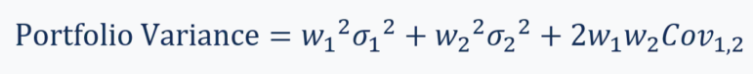

In [ ]:
#Defining Portfolio Performance 
def portfolioPerformance(weights, meanReturns, covMatrix):
  returns = np.sum(meanReturns * weights) * 252   #No. of Trading Day
  std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)    
  #Converting equation above to matrix form. Variance is add-able and we use 252 as it is the number of trading days.
  return returns, std

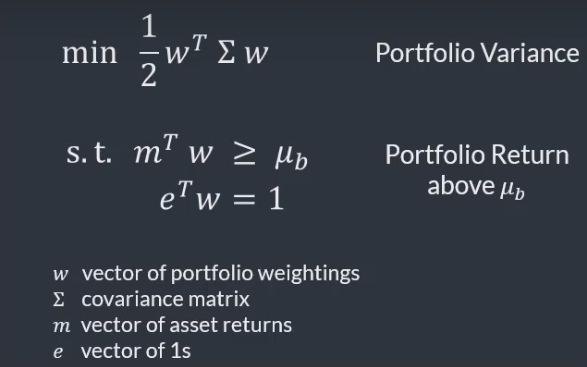

In [ ]:
def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
  pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
  return -(pReturns - riskFreeRate)/pStd  
  #Returning NSharpe Ratio as -(Excess Return over Market/Risk Taken)

In [ ]:
def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
  # Minimise the NegativeSR by altering the weights of the portfolio
  numAssets = len(meanReturns)
  args = (meanReturns, covMatrix, riskFreeRate)
  constraints = ({'type':'eq', 'fun': lambda x : np.sum(x) - 1})
  bound = constraintSet
  bounds = list(bound for asset in range(numAssets))
  result = sc.minimize(negativeSR, numAssets * [1./ numAssets], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)

  return result

In [ ]:
def portfolioVariance(weights, meanReturns, covMatrix):
  return portfolioPerformance(weights, meanReturns, covMatrix)[1]

In [ ]:
def portfolioReturn(weights, meanReturns, covMatrix):
  return portfolioPerformance(weights, meanReturns, covMatrix)[0]

In [ ]:
def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
  #Minimise the portfolio variance by altering the weights/allocation of assets in the portfolio
  numAssets = len(meanReturns)
  args = (meanReturns, covMatrix)
  constraints = ({'type':'eq', 'fun': lambda x : np.sum(x) - 1})
  bound = constraintSet
  bounds = list(bound for asset in range(numAssets))
  result = sc.minimize(portfolioVariance, numAssets * [1./ numAssets], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)

  return result

In [ ]:
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet = (0,1)):
  'For each returnTarget, we want to optimise the portfolio for minimum variance.'
  numAssets = len(meanReturns)
  args = (meanReturns, covMatrix)
  constraints = ({'type':'eq', 'fun':lambda x: portfolioReturn(x, meanReturns, covMatrix)- returnTarget},{'type':'eq', 'fun': lambda x : np.sum(x) - 1})  #Can be an inequality(>=)
  bound = constraintSet
  bounds = tuple(bound for asset in range(numAssets))
  effOpt = sc.minimize(portfolioVariance, numAssets * [1./numAssets], args = args, constraints = constraints, method = 'SLSQP', bounds = bounds)

  return effOpt

In [ ]:
stockList = ['CBA', 'BHP', 'TLS']
stocks = [stock + '.AX' for stock in stockList]

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365)

weights = np.array([0.33, 0, 0.67])

meanReturns, covMatrix = getData(stocks, start = startDate, end = endDate)
returns, std = portfolioPerformance(weights, meanReturns, covMatrix)


In [ ]:
MaxSRResult = maxSR(meanReturns, covMatrix)
MaxSR, MaxSRWeights = MaxSRResult['fun'], MaxSRResult['x']
print(MaxSR, MaxSRWeights)


-0.8728830851596426 [1.87392118e-01 1.66099773e-16 8.12607882e-01]


In [ ]:
MinVarResult = minimizeVariance(meanReturns, covMatrix)
minVar, minVarWeights = MinVarResult['fun'], MinVarResult['x']
print(minVar, minVarWeights)

0.14514339231312737 [0.27863366 0.13637941 0.58498693]


In [ ]:
def calculatedResults(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
  '''Function to read Mean, CovMatrix and other Financial Information
  Output Maximum Sharpe Ratio, Min Volatility and Efficient Frontier'''

  #For Maximum Sharpe Ratio
  maxSR_Portfolio = maxSR(meanReturns,covMatrix)
  maxSR_Returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
  maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index = meanReturns.index, columns = ['Allocation'])
  maxSR_allocation.Allocation = [round(i*100,0) for i in maxSR_allocation.Allocation]

  #For Min Volatitlity Portfolio
  minVol_Portfolio = minimizeVariance(meanReturns,covMatrix)
  minVol_Returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
  minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index = meanReturns.index, columns = ['Allocation'])
  minVol_allocation.Allocation = [round(i*100,0) for i in minVol_allocation.Allocation]

  
  #Efficient Frontier
  efficientList = []
  targetReturns = np.linspace(minVol_Returns, maxSR_Returns, 100)
  for target in targetReturns:
    efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])

  maxSR_Returns, maxSR_std = round(maxSR_Returns * 100,2), round(maxSR_std*100,2)
  minVol_Returns, minVol_std = round(minVol_Returns * 100,2), round(minVol_std*100,2)

  return maxSR_Returns, maxSR_std, maxSR_allocation, minVol_Returns, minVol_std, minVol_allocation, efficientList, targetReturns


In [ ]:
print(calculatedResults(meanReturns, covMatrix))

(13.53, 15.5,          Allocation
Symbols            
CBA.AX         19.0
BHP.AX          0.0
TLS.AX         81.0, 10.44, 14.51,          Allocation
Symbols            
CBA.AX         28.0
BHP.AX         14.0
TLS.AX         58.0, [0.1451433720468896, 0.14514388606930317, 0.14514623837545837, 0.14515042887604399, 0.14515645741193914, 0.1451643237539273, 0.14517402760363185, 0.1451855685923514, 0.14519894628216518, 0.1452141601651354, 0.14523120966476036, 0.14525009413436626, 0.14527081285842058, 0.1452933650520657, 0.1453177498624245, 0.14534396636588945, 0.1453720135727128, 0.14540189042286533, 0.14543359578836582, 0.14546712847406038, 0.14550248721724843, 0.1455396706855284, 0.14557867748233422, 0.14561950614147773, 0.14566215513246886, 0.1457066228532923, 0.14575290764337345, 0.14580100776979976, 0.1458509214375718, 0.14590264678524742, 0.14595618188730694, 0.14601152475183327, 0.14606867332427306, 0.14612762548776517, 0.14618837905846568, 0.1462509317921965, 0.14631528138169028, 0.1

In [ ]:
def EF_graph(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
  'Return a graph plotting the Min. Volatility, MaxSR and EfficientFrontier'
  maxSR_Returns, maxSR_std, maxSR_allocation, minVol_Returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix)
  
  #Max SR
  MaxSharpeRatio = go.Scatter(
      name = 'Maximum Sharpe Ratio',
      mode = 'markers',
      x = [maxSR_std],
      y = [maxSR_Returns],
      marker = dict(color = 'red', size = 14, line = dict(width = 3, color = 'black'))
  )

  #Min Vol.   
  MinVol = go.Scatter(
      name = 'Minimum Volatility',
      mode = 'markers',
      x = [minVol_std],
      y = [minVol_Returns],
      marker = dict(color = 'green', size = 14, line = dict(width = 3, color = 'black'))   
  )

  #Efficient Frontier   
  EF_curve = go.Scatter(
      name = 'Efficent Frontier',
      mode = 'lines',
      x = [round(ef_std*100, 2) for ef_std in efficientList],
      y = [round(target*100, 2) for target in targetReturns],
      line = dict(color = 'blue', width = 4, dash = 'dashdot')   
  )

  data = [MaxSharpeRatio, MinVol, EF_curve]

  layout = go.Layout(
      title = 'Portfolio Optimization with Efficient Frontier',
      yaxis = dict(title = 'Annualised Return(%)'),
      xaxis = dict(title = 'Annualised Volatility(%)'),
      width = 800,
      height = 600,      
      showlegend = True,
      legend = dict(
          x = 0.75, y = 0, traceorder = 'normal',
          bgcolor = '#E2E2E2',
          bordercolor = 'black',
          borderwidth = 2),
          )

  fig = go.Figure(data = data,layout = layout)
  return fig.show()
  


EF_graph(meanReturns, covMatrix)